In [1]:
# to ignore the warnings 
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# get the data from 

!wget https://www.dropbox.com/s/1nnj7xk0c46sxgg/BrainTumorData.zip?dl=0

# unzip the data
!unzip /content/BrainTumorData.zip?dl=0

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os 
import shutil
import math
import imutils



In [5]:
# count the number of images in the respective classes 

ROOT_DIR = "/content/BrainTumorData/Brain Tumor Data Set"

num_of_images = {}

for dir in os.listdir(ROOT_DIR):
  num_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

num_of_images

{'Brain Tumor': 2513, 'Healthey': 2087}

###we will split our data such that we have 
    * 70% for Train Data 
    * 15% for Validation 
    * 15% for Testing 

In [6]:
# we create a training folder 

if not os.path.exists("./train"):
  os.mkdir("./train")

  for dir in os.listdir(ROOT_DIR):
    os.makedirs("./train/"+dir)
    for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR, dir) ) , 
                                size= (math.floor(70/100*num_of_images[dir])-5) , replace=False ):
      
      O = os.path.join(ROOT_DIR,dir,img)
      D = os.path.join('./train', dir)
      shutil.copy(O,D)
      os.remove(O)
else:
  print("Train Folder exsist")

In [7]:
# we create a Validation folder 

if not os.path.exists("./val"):
  os.mkdir("./val")

  for dir in os.listdir(ROOT_DIR):
    os.makedirs("./val/"+dir)
    for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR, dir) ) , 
                                size= (math.floor(15/100*num_of_images[dir])-5) , replace=False ):
      
      O = os.path.join(ROOT_DIR,dir,img)
      D = os.path.join('./val', dir)
      shutil.copy(O,D)
      os.remove(O)
else:
  print("Train Folder exsist")

In [8]:
# we create a test folder 

if not os.path.exists("./test"):
  os.mkdir("./test")

  for dir in os.listdir(ROOT_DIR):
    os.makedirs("./test/"+dir)
    for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR, dir) ) , 
                                size= (math.floor(15/100*num_of_images[dir])-5) , replace=False ):
      
      O = os.path.join(ROOT_DIR,dir,img)
      D = os.path.join('./test', dir)
      shutil.copy(O,D)
      os.remove(O)
else:
  print("Train Folder exsist")

### WE have now sucessfully devided our data 

## Lets now build our model 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.preprocessing import image
import keras

## Transfer Learning Setup

In [10]:
base_model = MobileNet(input_shape=(224,224,3), include_top= False)

17227776/17225924 [==============================] - 0s 0us/step


In [11]:
for layer in base_model.layers:
  layer.trainable = False

In [12]:
x = Flatten()(base_model.output)
x = Dense(units=2 , activation='sigmoid', name = 'predictions' )(x)

# creating our model.
model = Model(base_model.input, x)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [31]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']  )

## Preparing our data using data generator 

In [32]:
train_datagen = image.ImageDataGenerator(
     zoom_range = 0.2, shear_range = 0.2 , rescale = 1./255 , horizontal_flip=True
)

val_datagen = image.ImageDataGenerator(rescale = 1./255)

test_datagen = image.ImageDataGenerator(rescale = 1./255)

In [33]:
train_data = train_datagen.flow_from_directory(directory= "/content/train", 
                                               target_size=(224,224), 
                                               batch_size=32,
                                  )

Found 3209 images belonging to 2 classes.


In [34]:
train_data.class_indices

{'Brain Tumor': 0, 'Healthey': 1}

In [35]:
val_data = val_datagen.flow_from_directory(directory= "/content/val", 
                                           target_size=(224,224), 
                                           batch_size=32,
                                  )

Found 679 images belonging to 2 classes.


In [36]:
test_data = test_datagen.flow_from_directory(directory= "/content/test", target_size=(224,224), batch_size=32)

Found 679 images belonging to 2 classes.


# visualizaing the data that is fed to test data gen

In [95]:
# to visualize the images in the traing data denerator 

t_img , label = train_data.next()

In [96]:
# function when called will prot the images 

def plotImages(img_arr, label):
  """
  input  :- images array 
  output :- plots the images 
  """

  for im, l in zip(img_arr,label) :
    plt.figure(figsize= (5,5))
    plt.imshow(im, cmap = 'gray')
    plt.title(im.shape)
    plt.axis = False
    plt.show()

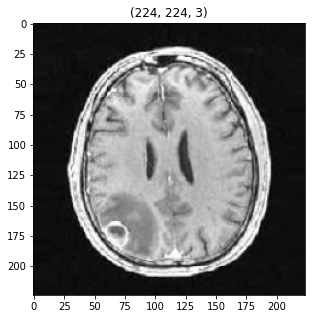

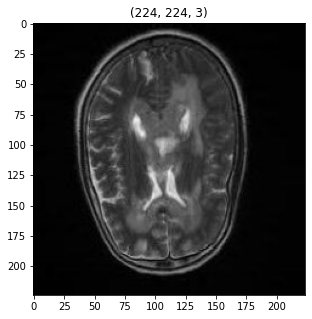

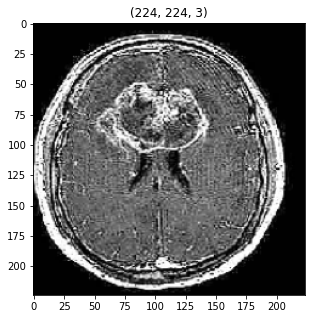

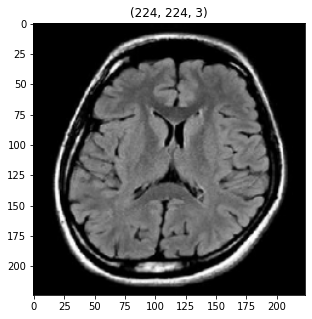

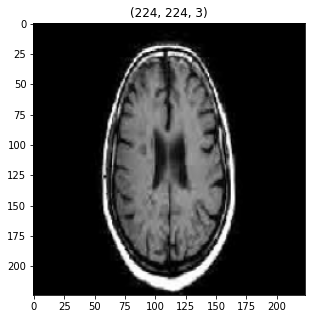

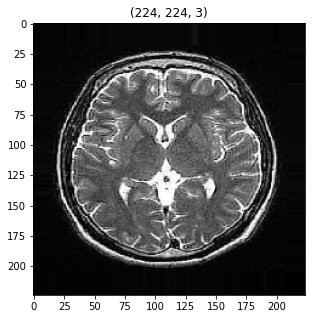

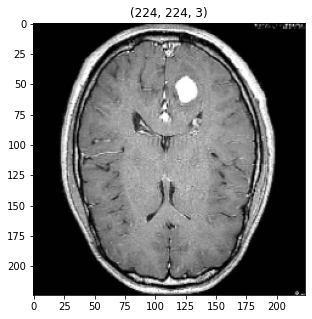

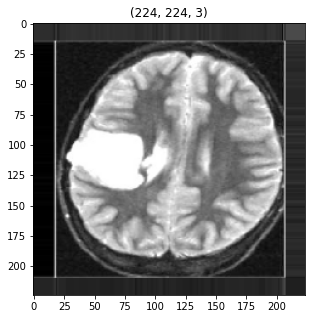

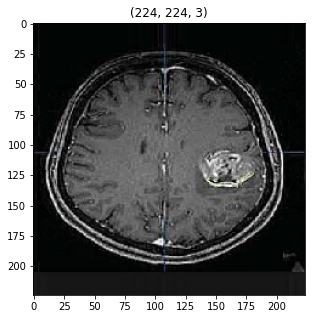

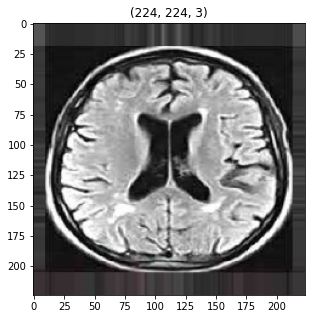

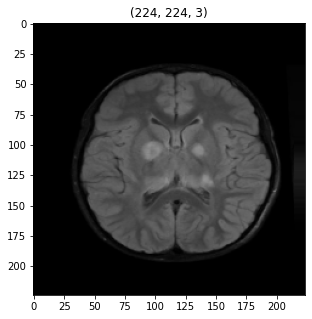

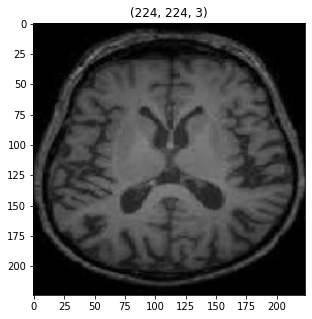

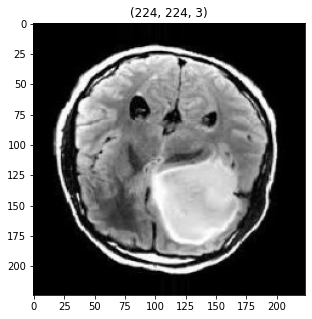

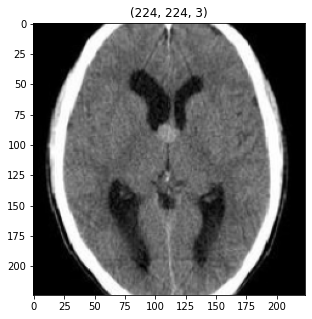

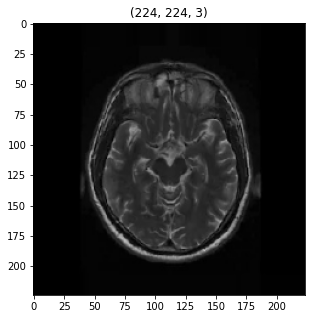

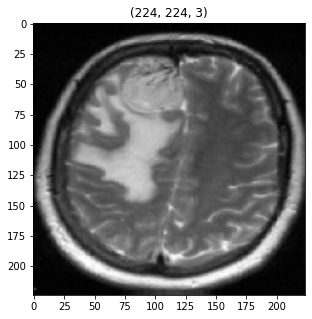

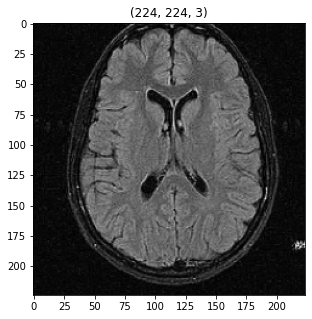

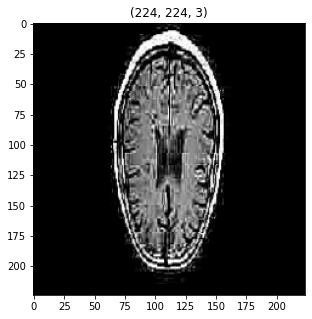

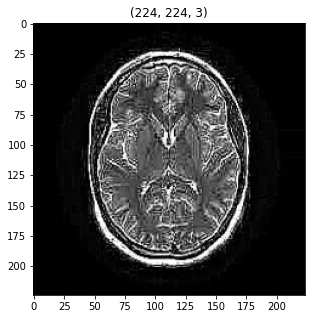

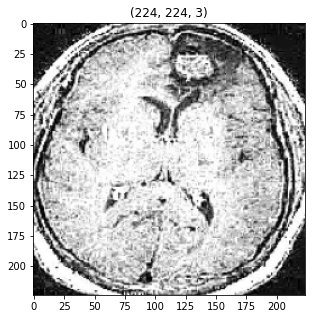

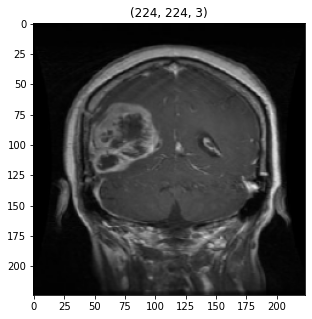

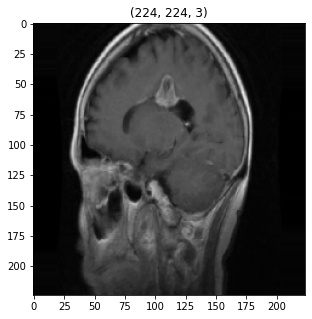

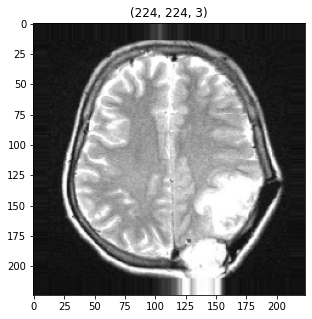

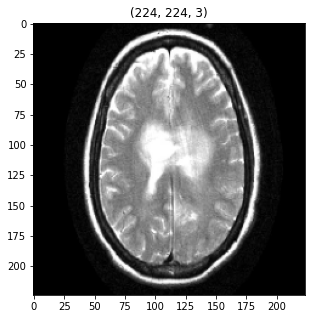

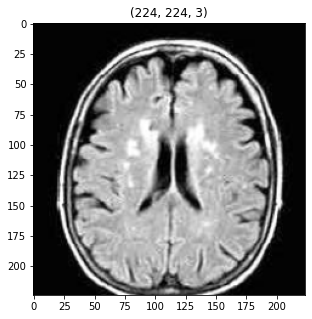

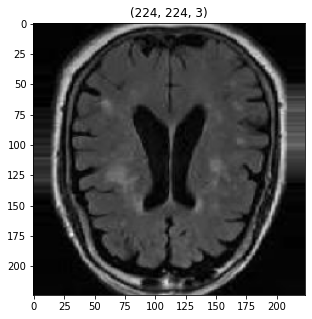

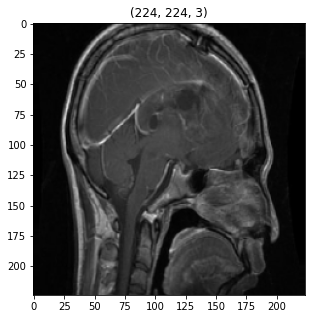

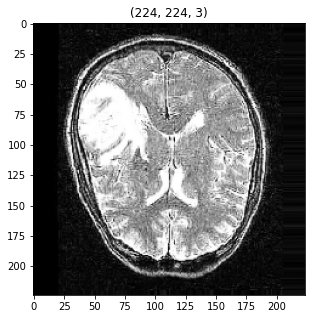

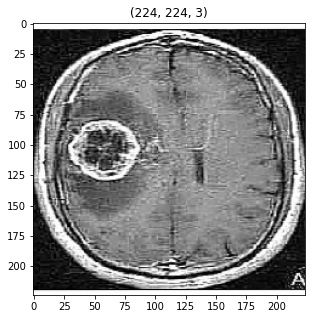

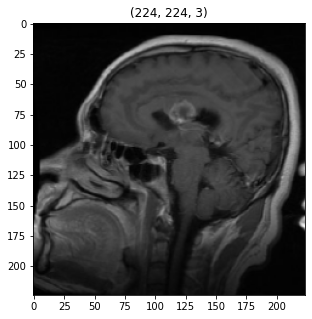

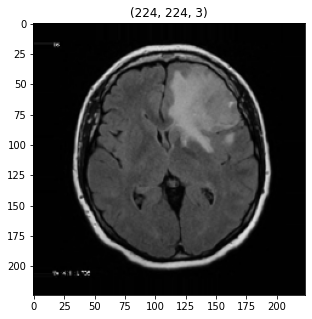

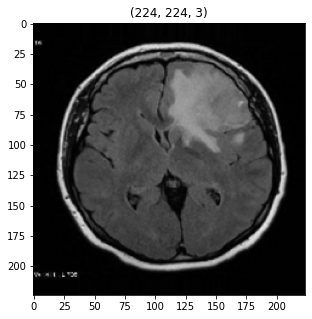

In [97]:
# function call to plot the images 

plotImages(t_img, label)

## having early stopping and model check point 

In [37]:
## having early stopping and model check point 

from keras.callbacks import ModelCheckpoint, EarlyStopping

# early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 5, verbose= 1, mode='auto')

# model check point
mc = ModelCheckpoint(filepath="best_model.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')

# puting call back in a list 
call_back = [es, mc]

In [38]:
hist = model.fit_generator(train_data, 
                           steps_per_epoch= 10, 
                           epochs= 30, 
                           validation_data= val_data, 
                           validation_steps= 16, 
                           callbacks=[es,mc])

Epoch 1/30
10/10 [==============================] - 8s 662ms/step - loss: 3.9917 - accuracy: 0.6259 - val_loss: 1.0231 - val_accuracy: 0.8516

Epoch 00001: val_accuracy improved from -inf to 0.85156, saving model to best_model.h5
Epoch 2/30
10/10 [==============================] - 6s 613ms/step - loss: 0.7626 - accuracy: 0.8380 - val_loss: 0.3906 - val_accuracy: 0.9062

Epoch 00002: val_accuracy improved from 0.85156 to 0.90625, saving model to best_model.h5
Epoch 3/30
10/10 [==============================] - 6s 608ms/step - loss: 0.4210 - accuracy: 0.8988 - val_loss: 0.2770 - val_accuracy: 0.9258

Epoch 00003: val_accuracy improved from 0.90625 to 0.92578, saving model to best_model.h5
Epoch 4/30
10/10 [==============================] - 6s 598ms/step - loss: 0.2684 - accuracy: 0.9335 - val_loss: 0.2043 - val_accuracy: 0.9492

Epoch 00004: val_accuracy improved from 0.92578 to 0.94922, saving model to best_model.h5
Epoch 5/30
10/10 [==============================] - 6s 589ms/step - los

In [39]:
# Loading the best fit model 
from keras.models import load_model
model = load_model("/content/best_model.h5")

In [40]:
h =  hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

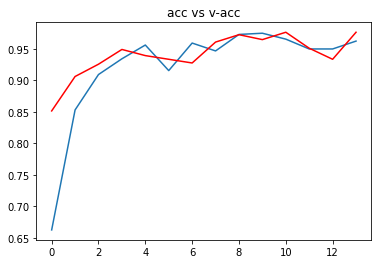

In [41]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

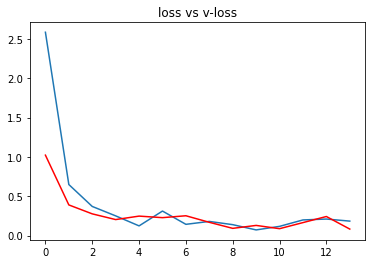

In [42]:
plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()

In [52]:
# checking out the accurscy of our model 

acc = model.evaluate_generator(generator= test_data)[1] 

print(f"The accuracy of your model is = {acc*100} %")

The accuracy of your model is = 96.9072163105011 %


The MRI image is of Healthey brain


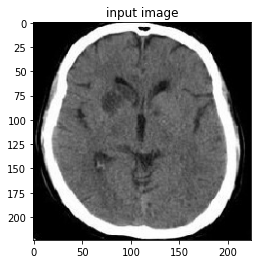

In [84]:
# path for the image to see if it predics correct class

path = "/content/val/Healthey/Not Cancer  (1121).jpg"
img = image.load_img(path, target_size=(224,224) )

i = image.img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))


if pred == 0:
  print("The MRI image is of BRAIN TUMOR")
else:
  print("The MRI image is of Healthey brain")


# to display the image  
plt.imshow(input_arr[0])
plt.title("input image")
plt.show()

## The GRAD-CAM visualization of feature map

In [61]:
from keras.preprocessing import image

def get_img_array(img_path):
  """
  Input : Takes in image path as input 
  Output : Gives out Pre-Processed image
  """
  path = img_path
  img = image.load_img(path, target_size=(224,224,3))
  img = image.img_to_array(img)
  img = np.expand_dims(img , axis= 0 )
  
  return img

In [62]:
import tensorflow as tf

In [63]:
# this function is udes to generate the heat map of aan image
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

## Now we will mask the heat map on the image

In [64]:
import matplotlib.cm as cm

from IPython.display import Image, display

In [65]:
def save_and_display_gradcam(img_path , heatmap, cam_path="cam.jpg", alpha=0.4):
    """
    img input shoud not be expanded 
    """

    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

In [92]:
# function that is used to predict the image type and the ares that are affected by covid


def image_prediction_and_visualization(path,last_conv_layer_name = "conv_pw_13", model = model):
  """
  input:  is the image path, name of last convolution layer , model name
  output : returs the predictions and the area that is effected
  """
  
  img_array = get_img_array(path)

  heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

  plt.title("the heat map of the image is ")
  plt.imshow(heatmap)
  plt.show()

  pred = np.argmax(model.predict(img_array/255))
  print()
  print()
  print()
  if pred == 0:
    print("The MRI image is of BRAIN TUMOR")
  else:
    print("The MRI image is of Healthey brain")

  print()
  print()
  print()
  print("image with heatmap representing region on interest")

  # function call
  save_and_display_gradcam(path, heatmap)

  print()
  print("the original input image")
  print()

  a = plt.imread(path)
  plt.imshow(a, cmap = "gray")
  plt.title("Original image")
  plt.show()

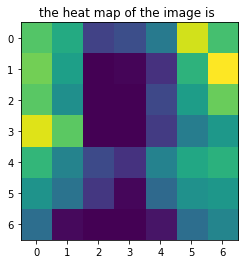


0

The MRI image is of BRAIN TUMOR



image with heatmap representing region on interest


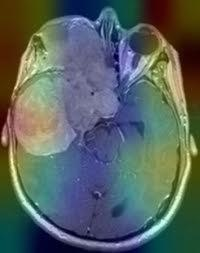


the original input image



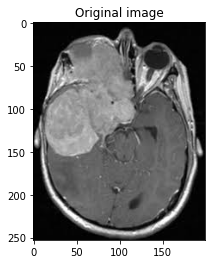

In [93]:

#predictions
# provide the path of any image from google or any other scource 
# the path is already defigned above , but you can also provide the path here to avoid scrolling up 

# for covid image :  path:- provide any image from google or provide image from all image folder
path = "/content/val/Brain Tumor/Cancer (1033).jpg"

image_prediction_and_visualization(path)

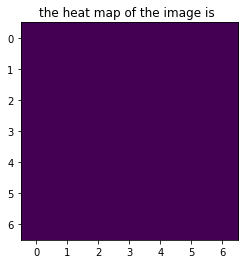


1

The MRI image is of Healthey brain



image with heatmap representing region on interest


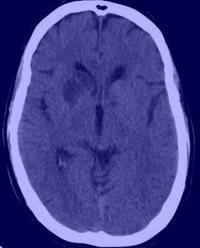


the original input image



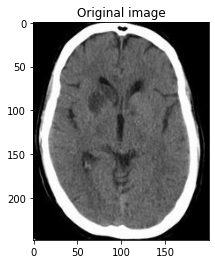

In [94]:
# for normal image :  path:- provide any image from google or provide image from all image folder
path = "/content/val/Healthey/Not Cancer  (1121).jpg"

image_prediction_and_visualization(path)

# for a healthey brain mri, heap map will be none thus the x-ray will look blue